In [57]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, LSTM, Embedding, Flatten
#from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.model_selection import GridSearchCV
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as seaborn
from sklearn.metrics import f1_score,confusion_matrix,accuracy_score,classification_report
#%%
# Python3 program to
# demonstrate instantiating
# a class
 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
cd /content/drive/MyDrive/Colab Notebooks


/content/drive/MyDrive/Colab Notebooks


In [37]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall*100

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision*100

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [38]:

class Analyzer:
     
    # A simple class
    # attribute
    dfbenign = pd.DataFrame()
    dfmalicious = pd.DataFrame()
    df = pd.DataFrame()
    def __init__(self):
        self.read_dataframes(True)
        
    def read_dataframes(self, min_path = False):
        df = pd.read_csv("pathInstructions.csv")
        df.columns = ['0','binary', 'pathlen', 'path']
        df.drop("0", axis =1,inplace=True)
        #print(len(df))
        df = df.drop_duplicates()
        df = df.reset_index(drop=True)
        df = df[df["pathlen"]<5000]
        if min_path:
            df = df.loc[df.groupby('binary').pathlen.idxmin()].reset_index(drop=True)
        dfbenign = df
        dfbenign["malicious"]=0
        df = pd.read_csv("pathInstructions2.csv")
        df.columns = ['0','binary', 'pathlen', 'path']
        df.drop("0", axis =1,inplace=True)
        if min_path:
            df = df.loc[df.groupby('binary').pathlen.idxmin()].reset_index(drop=True)
        
        dfmalicious = df
        dfmalicious["malicious"]=1
        self.dfbenign = dfbenign
        self.dfmalicious = dfmalicious
        df  = pd.concat([dfbenign,dfmalicious]).reset_index(drop=True)
        df['path'] = df['path'].apply(ast.literal_eval)
        self.df = df
        return dfbenign, dfmalicious

    def plot_stats(self):
        benignpath = self.dfbenign.path.values
        benign_instruction = list(map(lambda x: ast.literal_eval(x)[0], benignpath))
        #print(benign_instruction)
        plt.hist(benign_instruction,bins=25,rwidth=0.9);
        plt.xticks(rotation = 90) 
        plt.show()
        
        malpath = self.dfmalicious.path.values
        mal_instruction = list(map(lambda x: ast.literal_eval(x)[0], malpath))
        plt.hist(mal_instruction);
        plt.grid(True)
        plt.show()


    def data_clockgettime(self):
        temp = self.dfbenign
        path_data = temp['path'].tolist()
        path_series = pd.Series([ast.literal_eval(x)[0]=="call sym.imp.clock_gettime" for x in path_data])
        temp["drop"] = path_series
        temp = temp[temp["drop"]==True]
        temp = temp.drop(columns=["drop"])
        return pd.concat([temp,self.dfmalicious])
    
    def preprocess(self):
        def split_path(path):
            temp =[]
            for elem in path:
                temp.append(elem.split(" ")[0])
            return temp
        
        path = self.df.path.values
        modified_path  = list(map(lambda x: split_path(x), path))
        dfcopy = self.df
        dfcopy.path = modified_path


        instruction_set = set()
        for index,row in dfcopy.iterrows():
          instruction_set.update(row.path)

        for elem in instruction_set:
          dfcopy[elem]=0

        for index, row in dfcopy.iterrows():
          for elem in row.path:
            dfcopy.at[index,elem] += 1

        return dfcopy
        
    def create_model(self):
        input_length = int(len(self.df)*0.9)

        model = Sequential()
        model.add(Flatten())
        model.add(Dense(512, activation='sigmoid', input_shape=(63,), name='hidden_1'))
        model.add(Dense(256, activation='sigmoid', name='hidden_2'))
        model.add(Dense(128, activation='sigmoid', name='hidden_3'))
        model.add(Dense(64, activation='sigmoid', name='hidden_4'))
        model.add(Dense(1, activation='softmax', name='output_layer'))

    
        print ('Compiling...')
        model.compile(loss='binary_crossentropy',
                      optimizer=Adam(learning_rate=0.1),
                      metrics=['acc',f1_m,precision_m, recall_m])
        return model


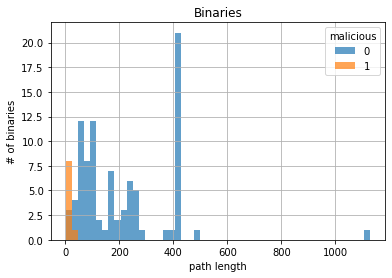

In [39]:
anal = Analyzer()
anal.df.pivot(columns='malicious', values='pathlen').plot.hist(bins=50,alpha=0.70)
plt.xlabel('path length')
plt.ylabel('# of binaries')
plt.title('Binaries')
plt.grid(True)

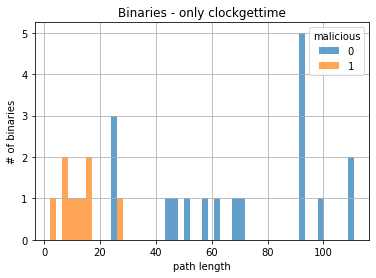

In [40]:
onlyclockgettime = anal.data_clockgettime()
onlyclockgettime.pivot(columns='malicious', values='pathlen').plot.hist(bins=50,alpha=0.70)
plt.xlabel('path length')
plt.ylabel('# of binaries')
plt.title('Binaries - only clockgettime')
plt.grid(True)


put values in one column

scale them

1 lstm -> SVM

2 SVM

In [41]:
df = anal.preprocess()
df.head()

,binary,pathlen,path,malicious,jb,call,rdtscp,rdtsc,setb,mov,...,rep,sbb,sete,jge,ja,imul,endbr64,cmovle,cld,not
0,arping,69,"[call, movzx, cmp, ja, test, je, mov, mov, mov...",0,0,4,0,0,0,8,...,0,0,0,0,1,0,0,0,0,0
1,brltty-trtxt,50,"[call, cmp, je, mov, xor, jne, add, pop, ret, ...",0,0,3,0,0,0,11,...,0,0,0,0,0,0,1,0,0,0
2,cabextract,374,"[call, mov, mov, mov, mov, call, mov, mov, mov...",0,0,8,0,0,0,47,...,0,1,0,0,0,0,0,0,0,1
3,chage,190,"[call, mov, mov, mov, mov, mov, lea, mov, mov,...",0,0,3,0,0,0,71,...,0,0,0,0,1,0,1,0,0,0
4,cpio,46,"[call, test, je, mov, xor, jne, add, pop, ret,...",0,0,3,0,0,0,6,...,0,0,0,0,0,0,1,0,0,0


In [62]:
y = df.malicious
X = df.drop(columns=['binary','pathlen','path'])
corr = X.corr()

X = X.drop(columns=['malicious'])
corr.style.background_gradient(cmap='coolwarm',axis=None).set_precision(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  


,malicious,jb,call,rdtscp,rdtsc,setb,mov,jg,setg,jne,rol,shr,sar,or,lea,cmove,movaps,test,js,je,jns,setge,jl,ret,cmovs,cdqe,cmovl,nop,seta,movups,pxor,setne,mfence,jle,jae,movsxd,jmp,clflush,sub,shl,push,and,cpuid,repe,cmp,add,movsx,lfence,pop,movabs,movzx,jbe,xor,rep,sbb,sete,jge,ja,imul,endbr64,cmovle,cld,not
malicious,1.000,-0.162,-0.321,0.320,0.872,-0.032,-0.266,-0.114,-0.032,-0.335,-0.045,-0.173,-0.195,0.289,-0.293,-0.032,-0.071,-0.351,-0.082,-0.345,-0.116,-0.032,-0.064,-0.252,-0.043,-0.032,-0.032,0.200,-0.057,-0.032,-0.079,-0.032,0.764,-0.006,-0.061,-0.109,-0.257,0.612,-0.282,0.121,-0.241,-0.081,0.320,-0.051,-0.293,-0.265,-0.060,0.649,-0.252,0.051,-0.107,-0.110,-0.328,-0.182,-0.071,-0.045,-0.055,-0.201,-0.074,-0.214,-0.055,-0.045,-0.032
jb,-0.162,1.000,0.742,-0.052,-0.141,-0.052,0.923,-0.187,-0.052,0.691,-0.074,0.915,0.927,-0.242,0.633,-0.052,-0.117,-0.078,-0.134,-0.027,-0.190,-0.052,-0.105,0.951,-0.070,-0.052,-0.052,0.505,-0.094,-0.052,-0.130,-0.052,-0.124,-0.144,-0.099,-0.179,0.763,-0.099,0.842,0.871,0.954,-0.133,-0.052,-0.084,0.655,0.871,-0.098,-0.105,0.910,-0.141,0.376,0.893,0.854,0.893,-0.117,-0.074,-0.091,0.807,-0.121,0.968,-0.091,-0.074,-0.052
call,-0.321,0.742,1.000,-0.105,-0.288,-0.053,0.877,-0.033,-0.053,0.773,0.224,0.682,0.696,-0.224,0.847,-0.000,-0.092,0.314,0.365,0.363,-0.109,-0.026,-0.127,0.810,-0.071,-0.026,-0.040,0.305,-0.054,0.131,-0.022,-0.079,-0.252,0.057,0.060,-0.056,0.788,-0.202,0.811,0.609,0.782,0.051,-0.105,-0.043,0.813,0.769,0.081,-0.214,0.785,-0.103,0.275,0.662,0.920,0.677,0.007,-0.056,-0.054,0.680,-0.034,0.767,-0.077,-0.056,-0.000
rdtscp,0.320,-0.052,-0.105,1.000,-0.028,-0.010,-0.060,-0.036,-0.010,-0.111,-0.014,-0.055,-0.062,0.424,-0.096,-0.010,-0.023,-0.112,-0.026,-0.110,-0.037,-0.010,-0.021,-0.080,-0.014,-0.010,-0.010,-0.058,-0.018,-0.010,-0.025,-0.010,0.718,-0.028,-0.019,-0.035,-0.091,0.754,-0.012,0.288,-0.077,-0.026,1.000,-0.016,-0.048,-0.085,-0.019,-0.021,-0.081,-0.028,-0.065,0.174,-0.105,-0.058,-0.023,-0.014,-0.018,-0.064,-0.024,-0.068,-0.018,-0.014,-0.010
rdtsc,0.872,-0.141,-0.288,-0.028,1.000,-0.028,-0.240,-0.100,-0.028,-0.289,-0.039,-0.151,-0.170,0.178,-0.254,-0.028,-0.062,-0.306,-0.071,-0.301,-0.101,-0.028,-0.056,-0.220,-0.037,-0.028,-0.028,0.269,-0.050,-0.028,-0.069,-0.028,0.586,-0.076,-0.053,-0.095,-0.249,0.400,-0.273,0.050,-0.210,-0.071,-0.028,-0.045,-0.280,-0.231,-0.052,0.744,-0.220,0.078,-0.070,-0.167,-0.286,-0.158,-0.062,-0.039,-0.048,-0.175,-0.065,-0.186,-0.048,-0.039,-0.028
setb,-0.032,-0.052,-0.053,-0.010,-0.028,1.000,-0.053,-0.036,-0.010,-0.041,-0.014,0.023,-0.062,0.110,-0.059,-0.010,-0.023,-0.047,-0.026,-0.075,-0.037,-0.010,-0.021,-0.080,-0.014,-0.010,-0.010,-0.058,0.210,-0.010,-0.025,-0.010,-0.024,-0.028,-0.019,0.269,-0.091,-0.019,0.032,0.052,-0.023,0.004,-0.010,-0.016,-0.048,-0.062,-0.019,-0.021,-0.081,-0.028,-0.065,-0.061,-0.042,-0.058,0.041,-0.014,-0.018,-0.064,-0.024,-0.068,-0.018,-0.014,-0.010
mov,-0.266,0.923,0.877,-0.060,-0.240,-0.053,1.000,-0.028,-0.087,0.812,0.071,0.872,0.888,-0.194,0.824,0.020,-0.116,0.203,0.086,0.211,-0.112,0.022,-0.148,0.940,-0.051,0.022,-0.036,0.436,-0.035,0.042,-0.091,-0.087,-0.191,0.025,0.031,-0.018,0.871,-0.146,0.913,0.787,0.947,0.039,-0.060,-0.024,0.822,0.929,0.038,-0.175,0.911,-0.083,0.437,0.843,0.949,0.844,0.029,-0.058,-0.066,0.807,-0.017,0.934,-0.052,-0.058,0.020
jg,-0.114,-0.187,-0.033,-0.036,-0.100,-0.036,-0.028,1.000,-0.036,0.113,0.085,-0.170,-0.133,0.248,0.123,-0.036,0.011,0.295,0.167,0.234,0.219,-0.036,-0.074,-0.204,-0.049,-0.036,-0.036,-0.001,-0.023,-0.036,-0.011,-0.036,-0.087,0.209,-0.070,0.365,-0.056,-0.070,-0.068,-0.194,-0.149,-0.042,-0.036,-0.015,0.122,-0.042,0.096,-0.074,-0.142,-0.100,0.317,-0.221,-0.002,-0.121,-0.070,0.221,-0.064,0.063,-0.086,-0.198,-0.064,0.221,-0.036
setg,-0.032,-0.052,-0.053,-0.010,-0.028,-0.010,-0.087,-0.036,1.000,-0.111,-0.014,-0.055,-0.062,-0.047,-0.096,-0.010,-0.023,-0.080,-0.026,-0.075,-0.037,-0.010,-0.021,-0.043,-0.014,-0.010,-0.010,-0.058,-0.018,-0.010,-0.025,-0.010,-0.024,-0.028,-0.019,-0.035,-0.09

In [75]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))


In [76]:
y_test

83    0
53    0
70    0
45    0
44    0
39    0
22    0
80    0
10    0
0     0
18    0
30    0
73    0
33    0
90    0
4     0
76    0
77    0
12    0
31    0
55    0
88    0
26    0
42    0
69    0
15    0
40    0
96    1
9     0
72    0
11    0
47    0
85    0
28    0
93    1
5     0
66    0
65    0
35    0
16    0
Name: malicious, dtype: int64

In [77]:
len(X_train),len(X_test),len(y_train),len(y_test)

(60, 40, 60, 40)

In [78]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()


tree.fit(X_train, y_train)
y_pred = tree.predict(X_test) 



In [79]:
from sklearn.metrics import f1_score, accuracy_score,recall_score

print(f1_score(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(recall_score(y_test,y_pred))

0.8
0.975
1.0


In [52]:
X_train.shape

(90, 62)

In [53]:
y_train.shape

(90,)

In [54]:
model = anal.create_model()

Compiling...


In [ ]:
print ('Fitting model...')
hist = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split = 0.1, verbose = 1)
score = model.evaluate(X_test, y_test, batch_size=1)
print('Test score:', score)
#print('Test accuracy:', acc)


*****Confusion Matrix*****



<function matplotlib.pyplot.show>

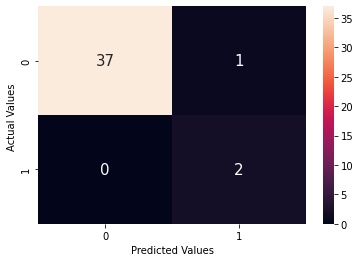

In [80]:
print("\n*****Confusion Matrix*****\n")
confMatrix = confusion_matrix(y_test, y_pred)

#For the following part I helped from https://www.delftstack.com/howto/python/plot-confusion-matrix-in-python/
fx = seaborn.heatmap(confMatrix, annot=True,annot_kws={"size": 15},fmt='g')

# labels the title and x, y axis of plot
fx.set_xlabel('Predicted Values')
fx.set_ylabel('Actual Values ');

# labels the boxes
fx.xaxis.set_ticklabels(['0','1'])
fx.yaxis.set_ticklabels(['0','1'])

plt.show

In [61]:
print(y_pred)

[0 0 0 0 0 0 0 0 0 0]
